100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]


max OA:99.45 %, each iteration :1.30 seconds, all iterations: 30,all time: 8.69 seconds . 


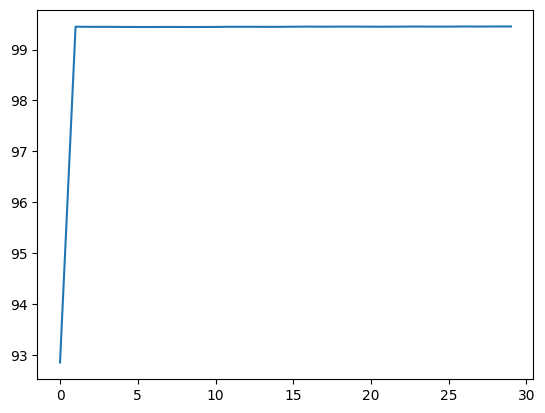

In [1]:
# -*- coding: utf-8 -*-
"""
@author: yaqiu Zhang
zyq_zyq_q@163.com
"""
from scipy.io import loadmat
import numpy as np
from scipy.fft import fft2, ifft2
from sklearn.metrics import accuracy_score
def Dh(x):
    return np.real(ifft2(fft2(x) * FDh))
def DhH(x):
    return np.real(ifft2(fft2(x) * FDhH))
def Dv(x):
    return np.real(ifft2(fft2(x) * FDv))
def DvH(x):
    return np.real(ifft2(fft2(x) * FDvH))

def soft(x, T):
    T = T + np.finfo(float).eps  
    y = np.maximum(np.abs(x) - T, 0)
    return y / (y + T) * x

def update_samples_acc():
    max_indices = classification1[img_label[0,:]]
    mask = np.isin(img_label[0, :], train1[0, :])
    indices_in_img_label = np.where(mask)[0]
    max_indices[indices_in_img_label] = train1[1, :]
    sorted_new_y = train1[:, np.argsort(train1[1])]
    max_indices[indices_in_img_label] = sorted_new_y[1, :]
    return accuracy_score(img_label[1, :], max_indices) * 100

p = np.load('p_xuzhou.npy').T
train1 = np.load('train_label.npy')
img_label = np.load('all_label.npy')
index = train1[0,:]
shape = np.shape(p)
n=shape[0]
Traning_gp_matrix = np.eye(n)[train1[1,:] - 1].T
mu = 0.05
img_shape = (500,260)

FDh = np.zeros(img_shape)
FDh[0, 0] = -1
FDh[0, -1] = 1

FDv = np.zeros(img_shape)
FDv[0, 0] = -1
FDv[-1, 0] = 1

FDh = fft2(FDh)
FDhH = np.conj(FDh)
FDv = fft2(FDv)
FDvH = np.conj(FDv)

IL = 1.0 / (FDhH * FDh + FDvH * FDv + 1)
V1_im = np.zeros(((*img_shape, n)))
n_reg = 3
IF = (1 / (1 + n_reg)) * np.eye(n)
U = np.dot(IF, p)
V,D = {}, {}
V[1] = U 
D[1] = np.zeros(shape)
U_im = np.reshape(U.T, (*img_shape, n))
V[2],D[2] = [],[]
for _ in range(n):
    V2_i = [None, None]
    D2_i = [None, None]
    V[2].append(V2_i)
    D[2].append(D2_i)

for i in range(n):
    V[2][i][0] = Dh(U_im[:, :, i])
    V[2][i][1] = Dv(U_im[:, :, i])
    D[2][i][0] = np.zeros(img_shape)
    D[2][i][1] = np.zeros(img_shape)
    
V[3] = U 
D[3] = np.zeros(shape)
from tqdm import tqdm
result=[]
import time 
strat_time = time.time()
###################### main code ######################
for i in tqdm(range(30)):
    Xi = V[1] + D[1] + V[3] + D[3]
    n_aux = 1 / (1 + 2 * mu) * (p + mu * Xi)
    U = n_aux + np.tile((1 - np.sum(n_aux, axis=0)) / n, (n, 1))
    U[:, index] = Traning_gp_matrix
    nu_aux = U - D[1]
    nu_aux_im = np.reshape(nu_aux.T, (img_shape [0], img_shape [1], n))
    rot = 2
    for k in range(n):
        V1_im[:, :, k] = np.real(ifft2(IL * fft2(DhH(V[2][k][0] + D[2][k][0]) + DvH(V[2][k][1] + D[2][k][1]) + nu_aux_im[:, :, k])))
        V[2][k][0] = soft(Dh(V1_im[:, :, k]) - D[2][k][0], rot/mu)
        V[2][k][1] = soft(Dv(V1_im[:, :, k]) - D[2][k][1], rot/mu)
        D[2][k][0] -= Dh(V1_im[:, :, k]) - V[2][k][0]
        D[2][k][1] -= Dv(V1_im[:, :, k]) - V[2][k][1]
    V[1] = np.reshape(V1_im, (np.prod(img_shape), n)).T
    V[3] = np.maximum(U - D[3], 0) 
    D[1] = D[1] - U + V[1]
    D[3] = D[3] - U + V[3]
    classification1 = np.argmax(U, axis=0)+1 
    OA_GP=sum(classification1[img_label[0,:]]==img_label[1,:] )/len(img_label[1,:]) 
    result.append("{:.6f}".format(OA_GP))
classification_oa = np.array(result).astype(np.float64)*100
end_time = time.time()
all_time = end_time- strat_time
print('max OA:{:.2f} %, each iteration :{:.2f} seconds, all iterations: {},all time: {:.2f} seconds . '.format(max(classification_oa),all_time/i+1,i+1,all_time))
import matplotlib.pyplot as plt
plt.plot(classification_oa)
plt.show()


SVGP Classification


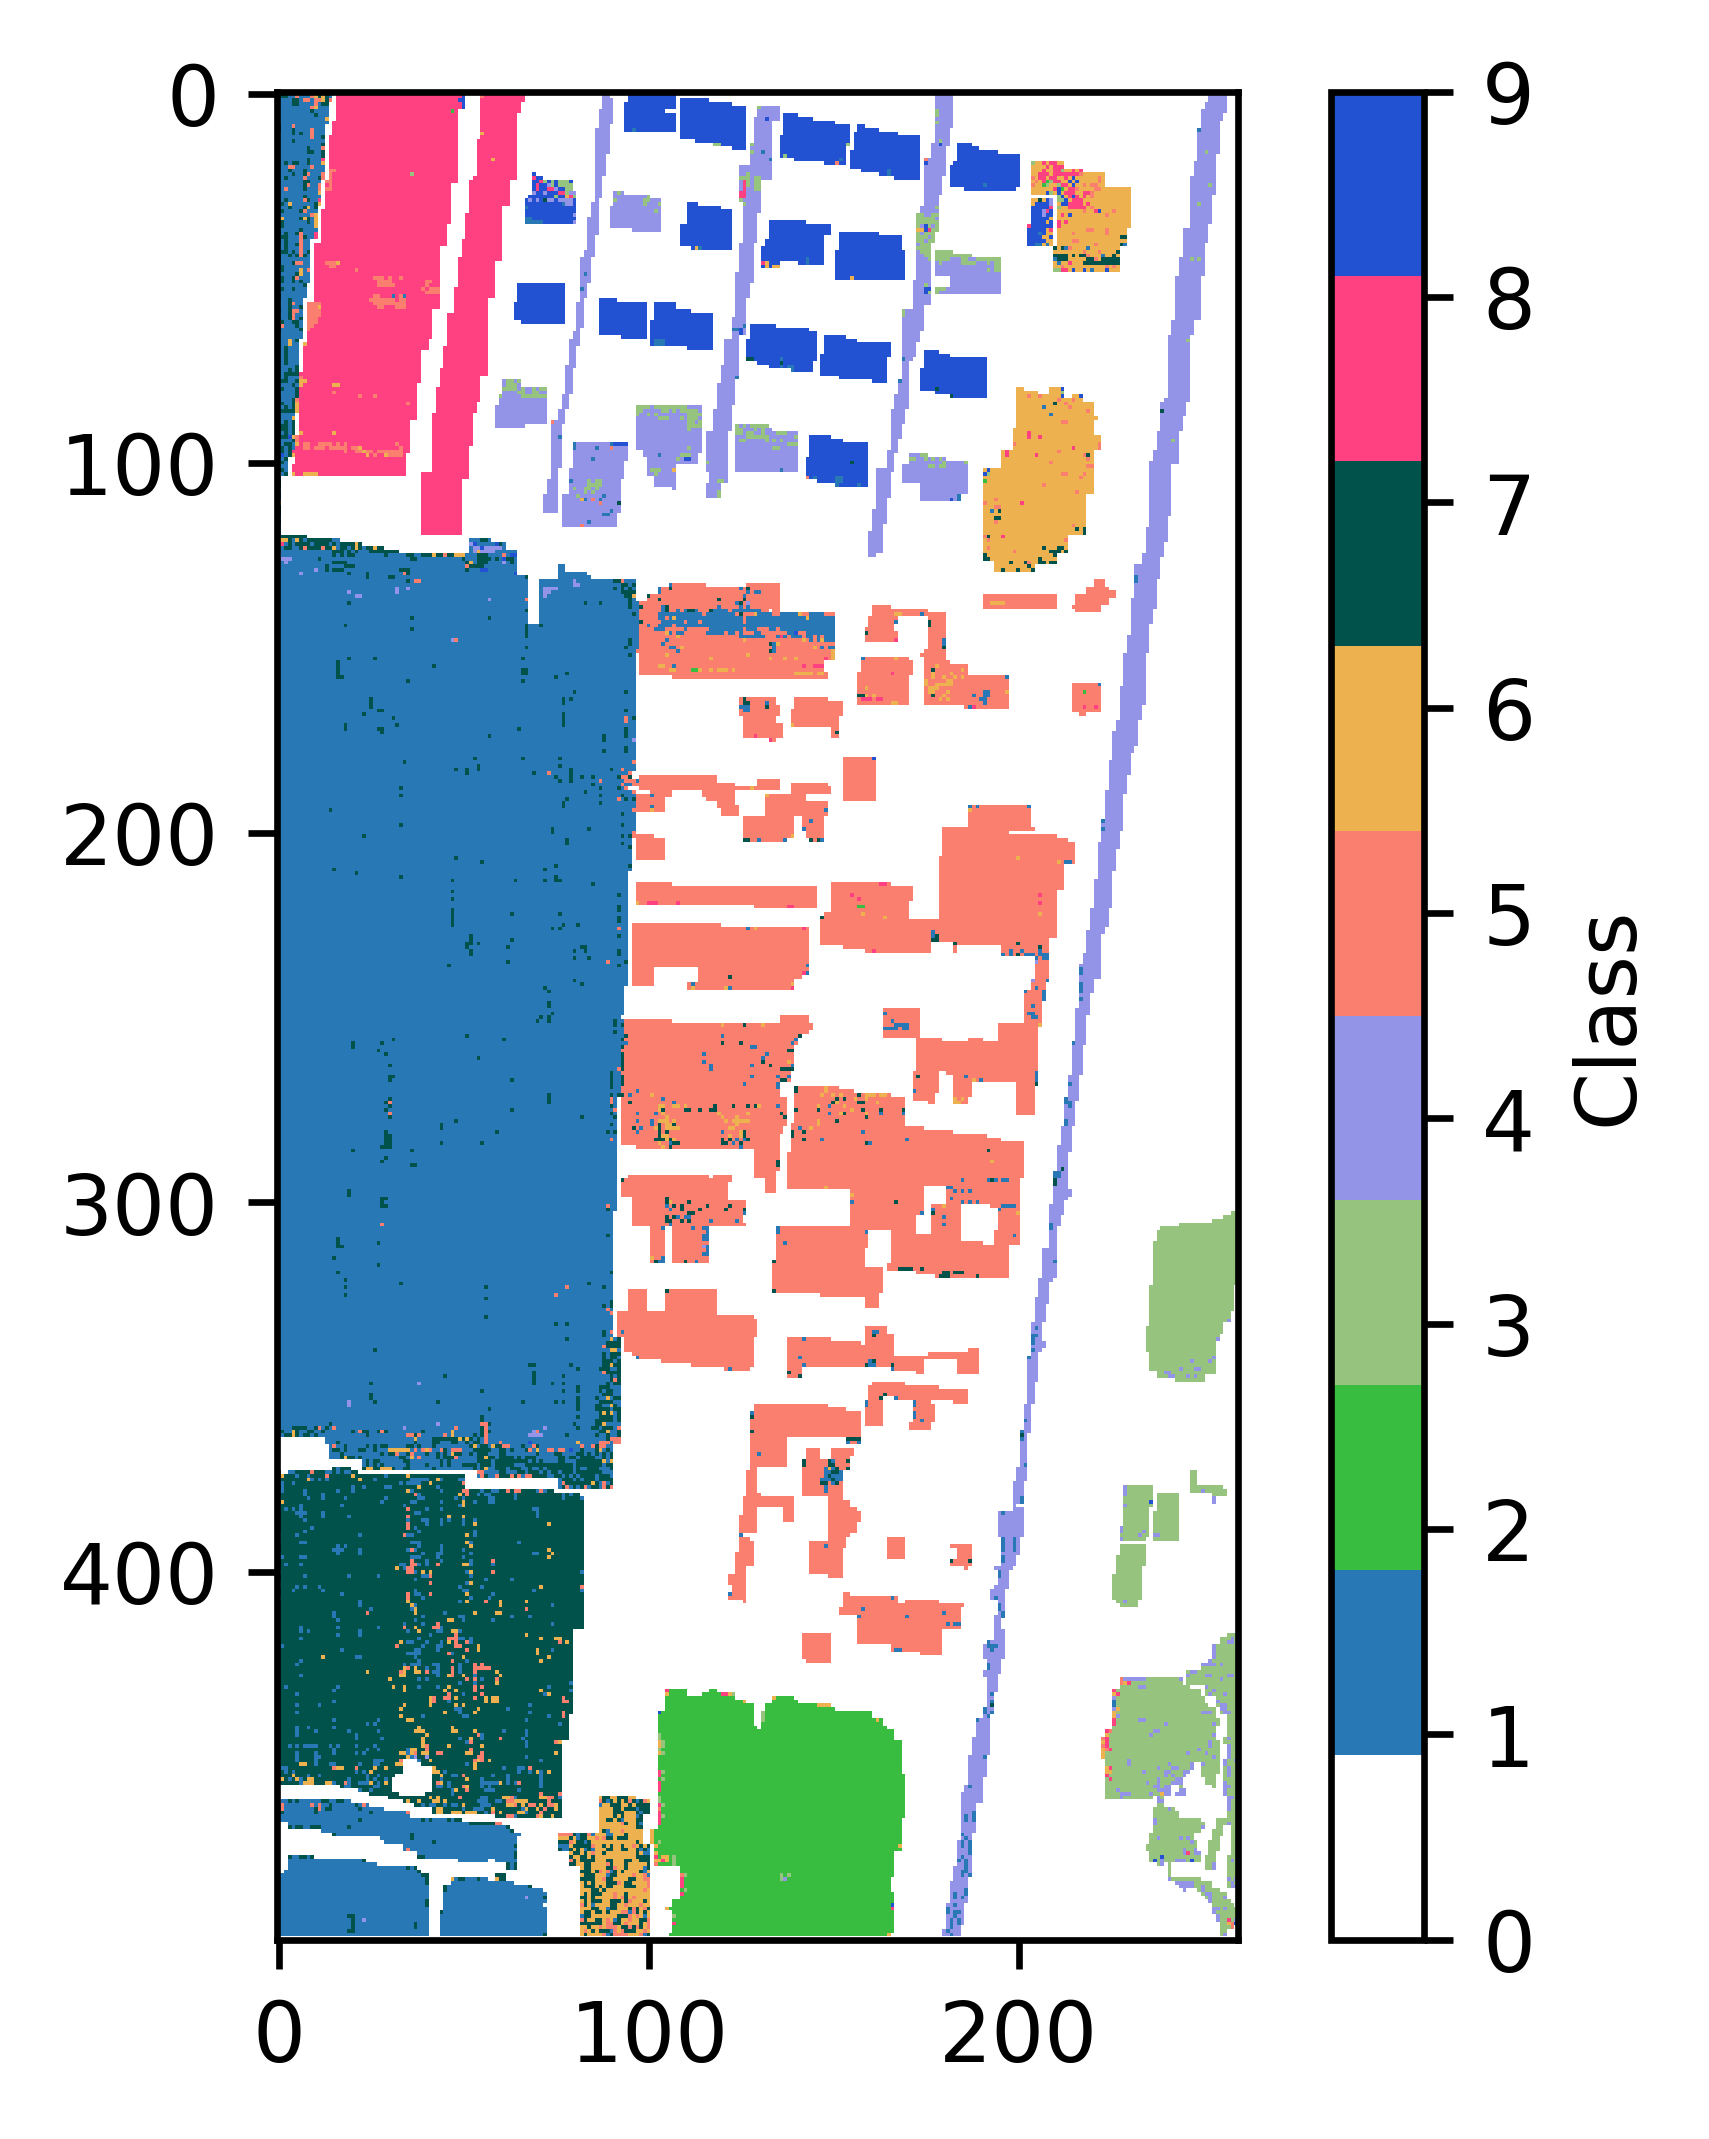

In [2]:
#SVGP
print("SVGP Classification")
img_ture = np.zeros(p.shape[1])
classification2 = np.argmax(p, axis=0)+1 
img_ture[img_label[0]] = classification2[img_label[0]]
img_ture[train1[0]]=train1[1]
img_ture1=img_ture.reshape(img_shape)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
colors = ['#FFFFFF', '#2878B5', '#38bd40', '#96C37D', '#9394E7', '#FA7F6F', '#eeb14f', '#00524b', '#ff4081',
          '#2251d1', ]
cmap = ListedColormap(colors)
plt.figure(figsize=(4, 4),dpi=600)
plt.imshow(img_ture1, cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.colorbar(ticks=range(len(colors)), label='Class')
plt.show()

SVGP-SpAR Classification


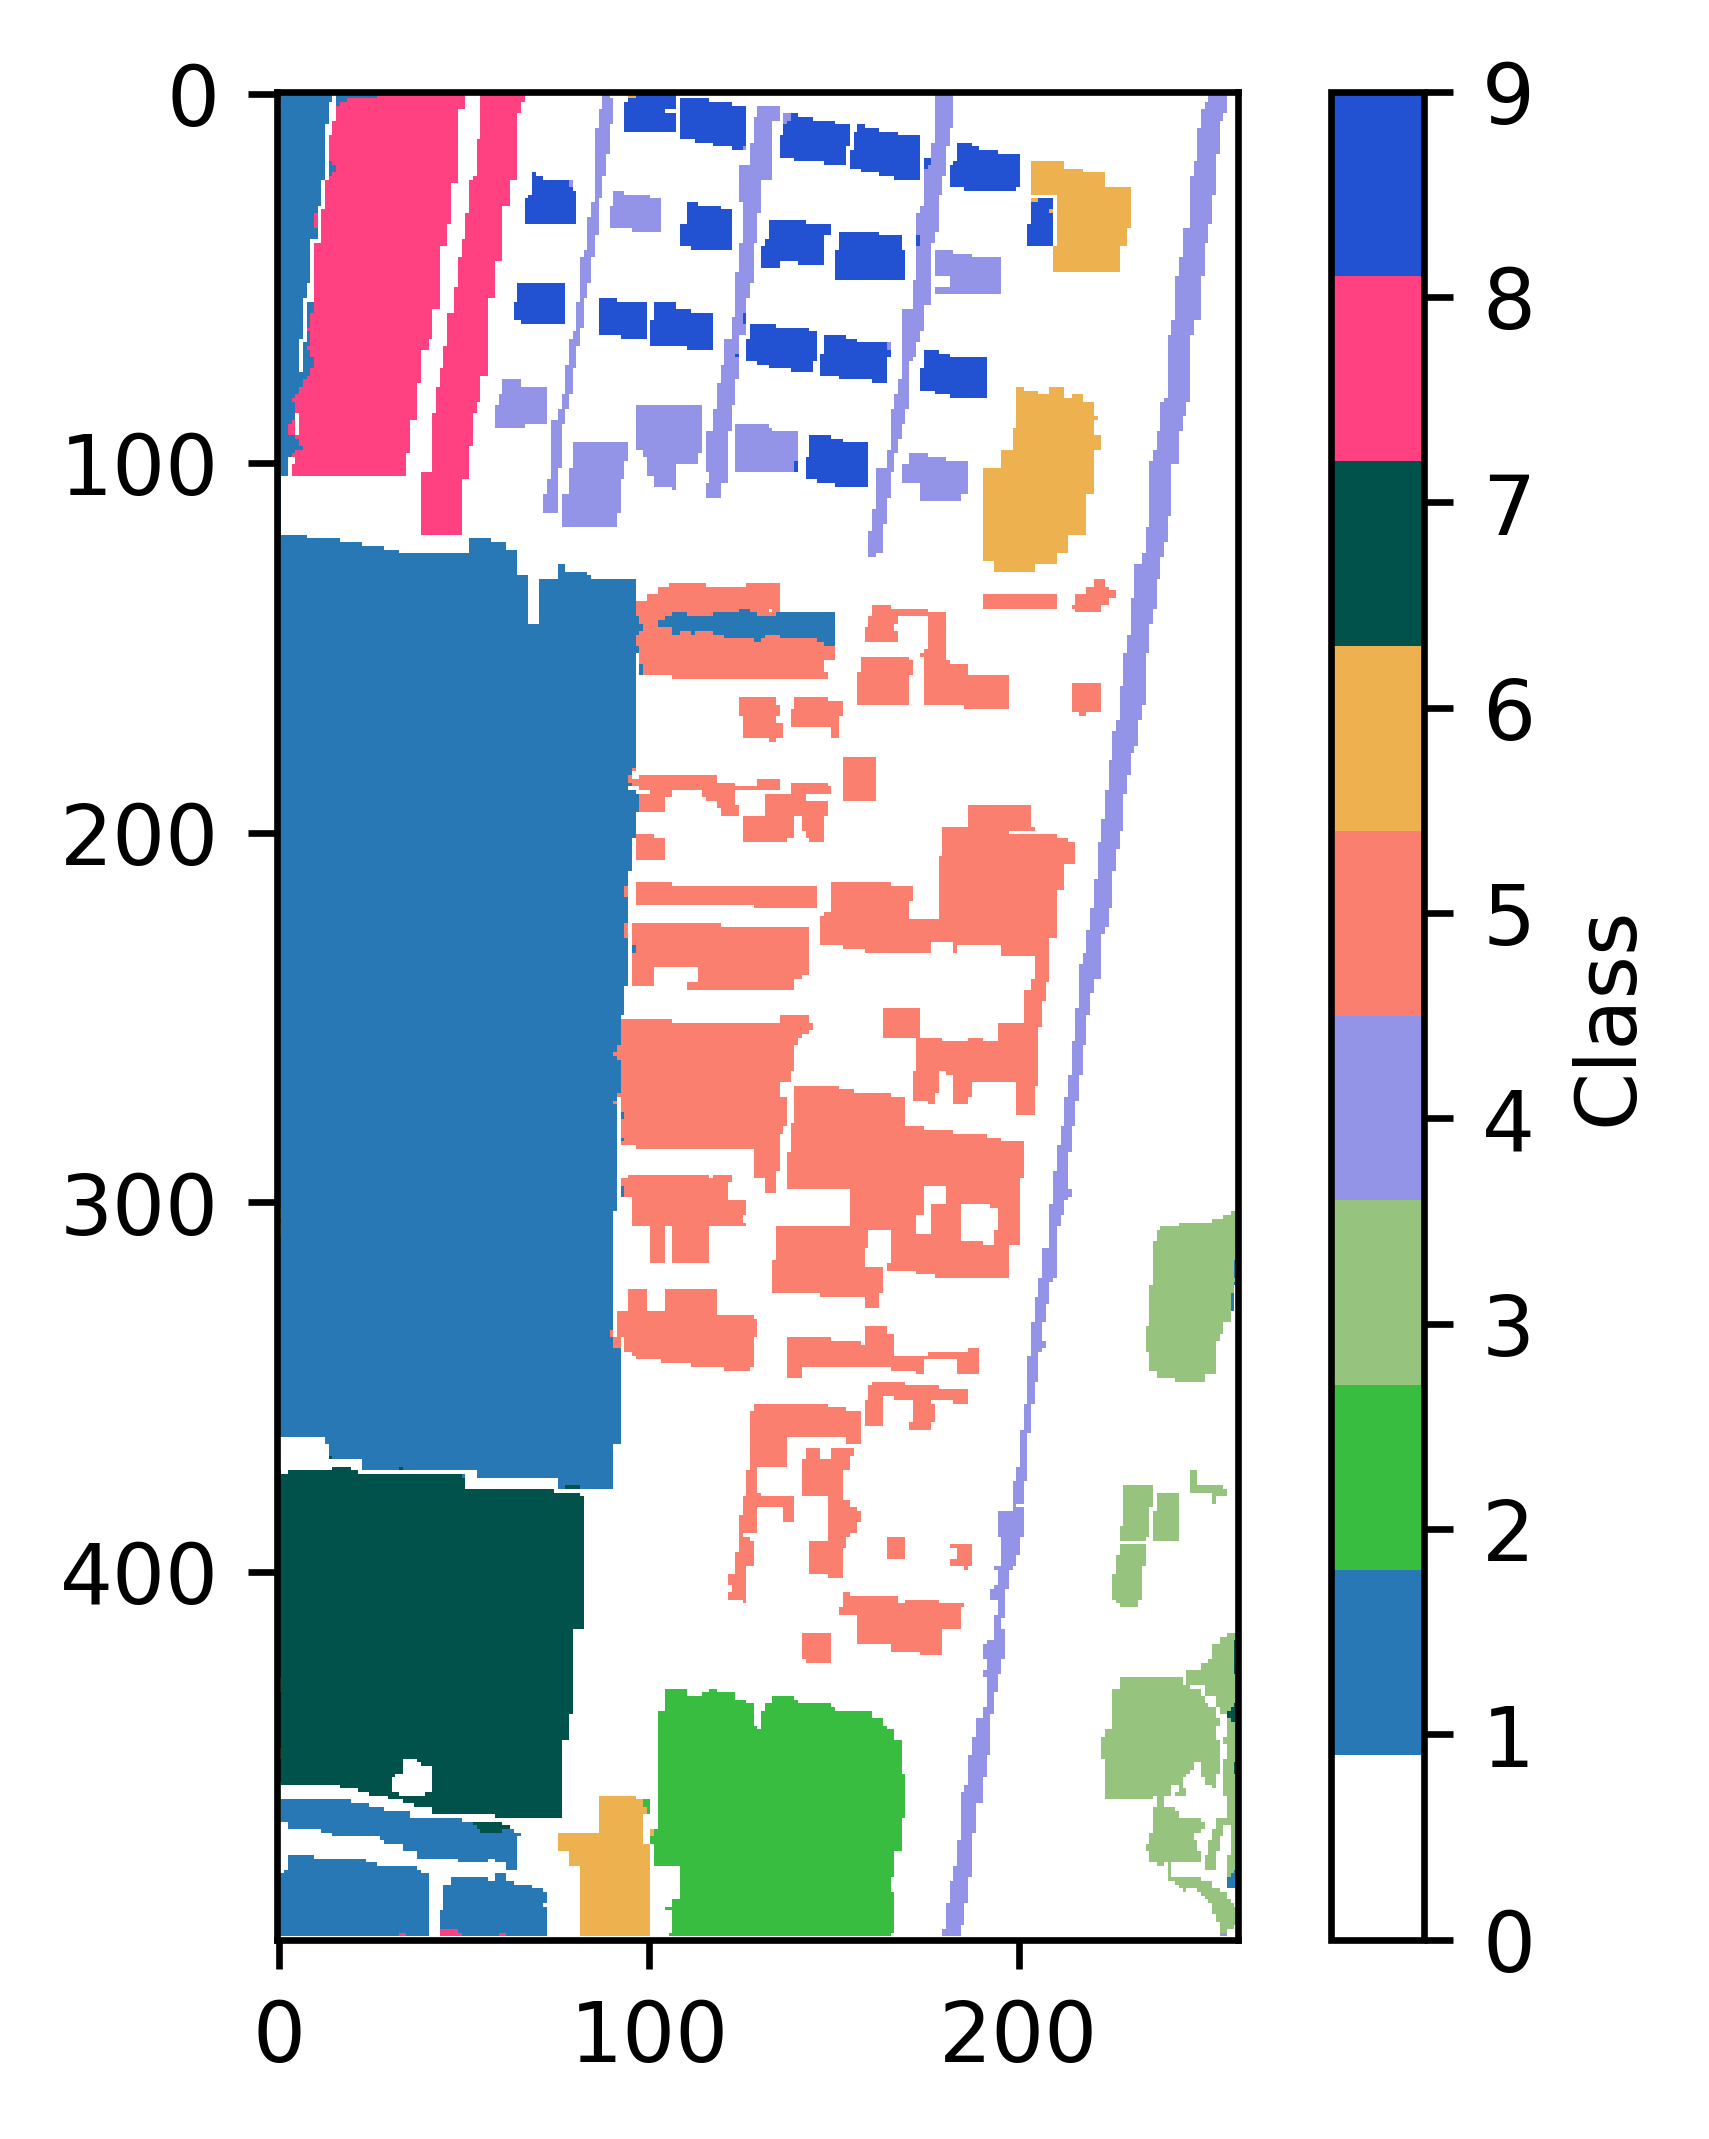

In [3]:
#SVGP-SpAR
print("SVGP-SpAR Classification")
img_ture = np.zeros(p.shape[1])
img_ture[img_label[0]] = classification1[img_label[0]]
img_ture[train1[0]]=train1[1]
img_ture1=img_ture.reshape(img_shape)
cmap = ListedColormap(colors)
plt.figure(figsize=(4, 4),dpi=600)
plt.imshow(img_ture1, cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.colorbar(ticks=range(len(colors)), label='Class')
plt.show()

truth image


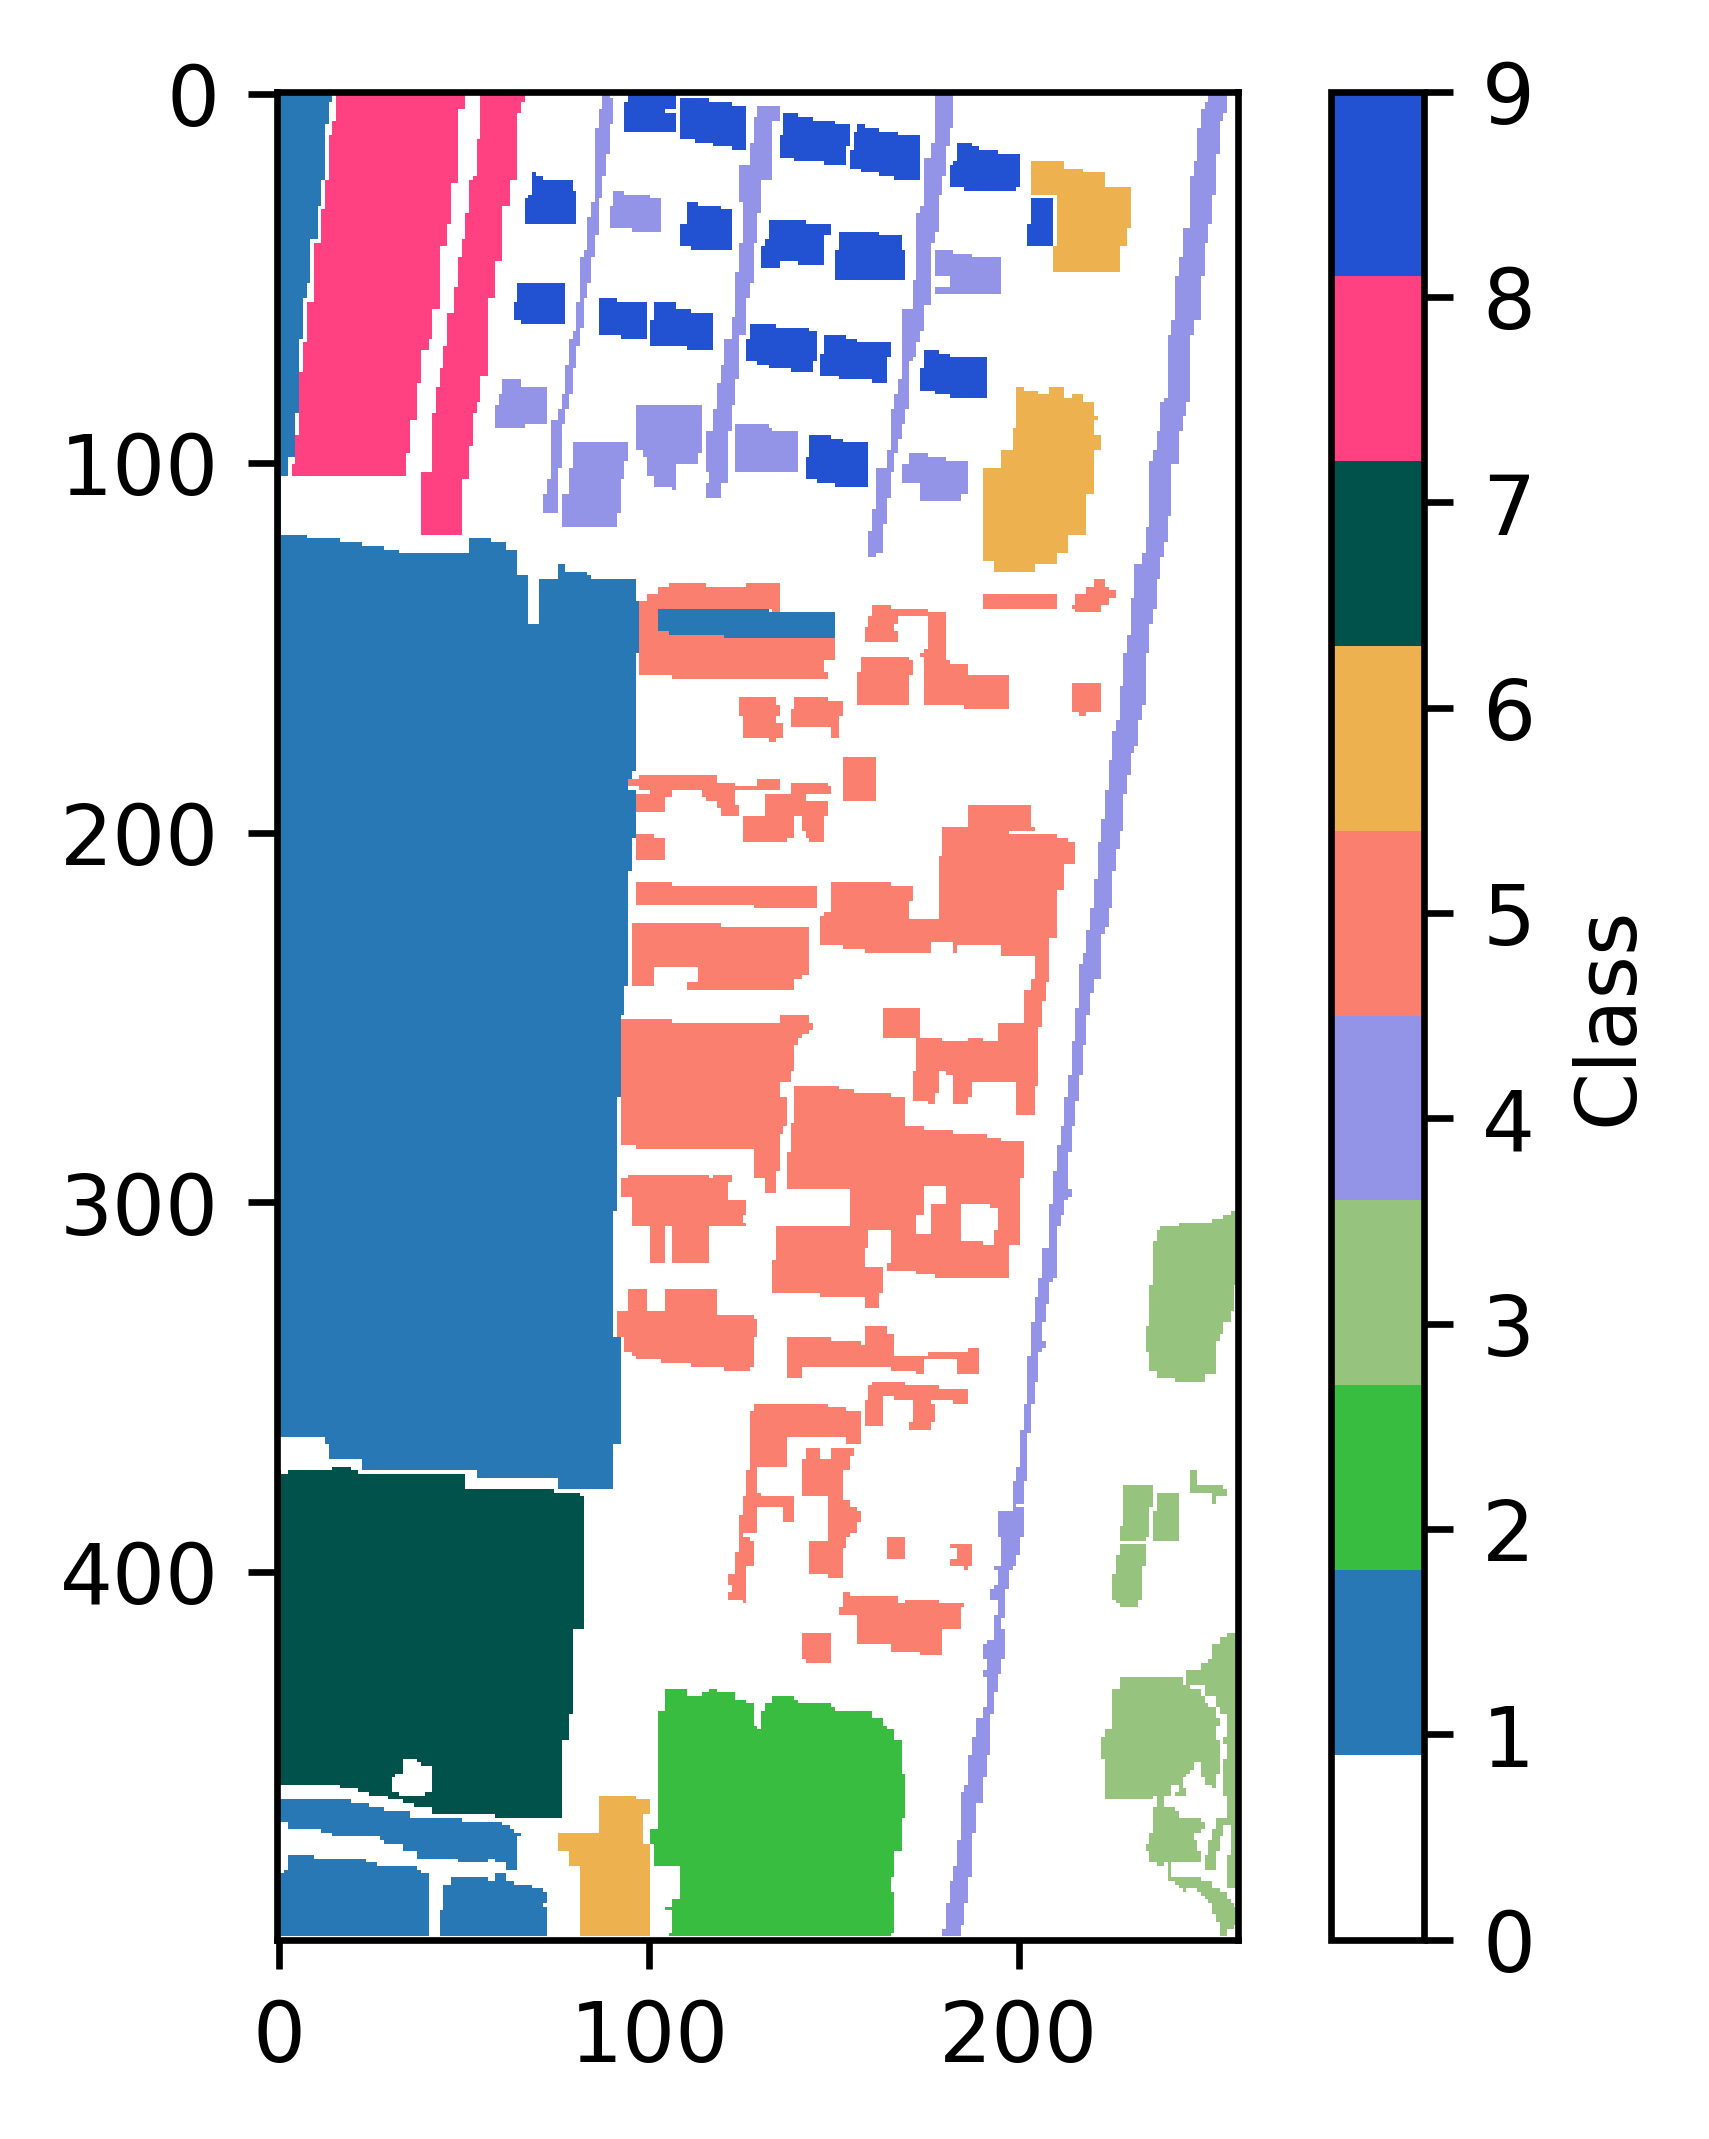

In [4]:
print("truth image")
img_ture = np.zeros(p.shape[1])
img_ture[img_label[0]] = img_label[1]
img_ture[train1[0]]=train1[1]
img_ture1=img_ture.reshape(img_shape)
cmap = ListedColormap(colors)
plt.figure(figsize=(4, 4),dpi=600)
plt.imshow(img_ture1, cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.colorbar(ticks=range(len(colors)), label='Class')
plt.show()

MRF Classification


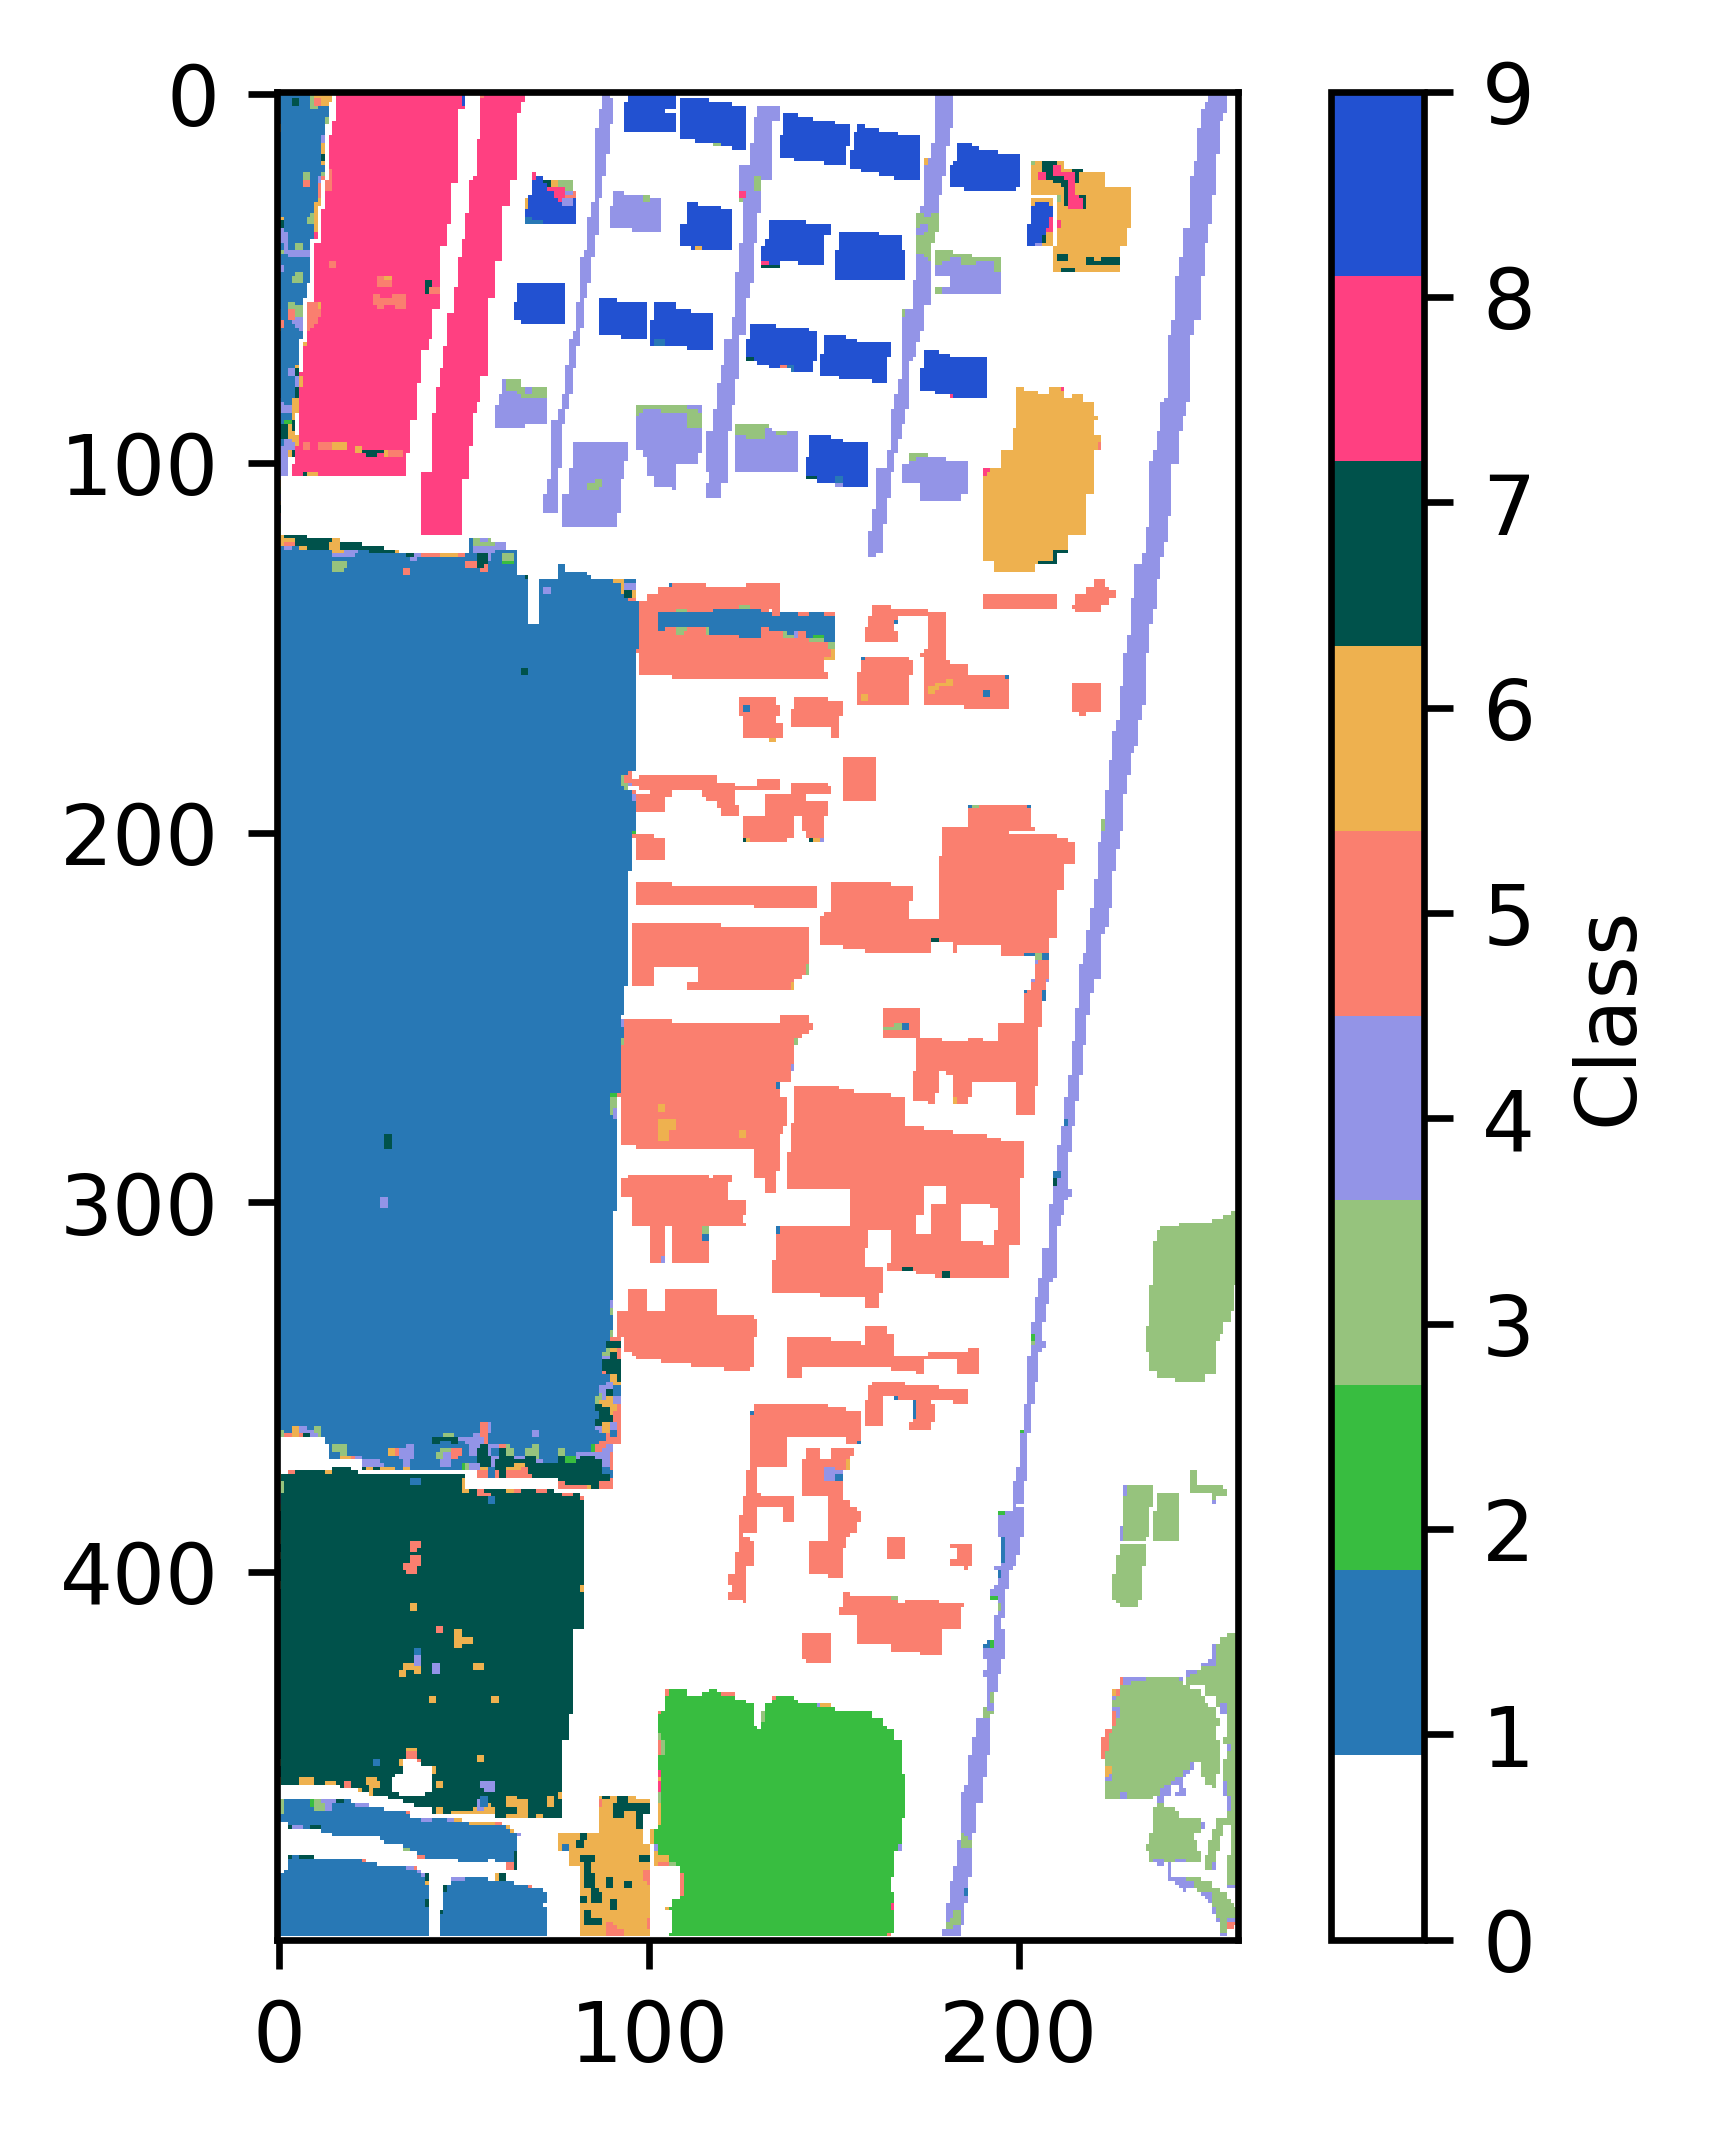

In [5]:
#xuzhou_MRF
print("MRF Classification")
mrf_xuzhou = np.load('mrf_xuzhou.npy')
cmap = ListedColormap(colors)
plt.figure(figsize=(4, 4),dpi=600)
plt.imshow(mrf_xuzhou, cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.colorbar(ticks=range(len(colors)), label='Class')
plt.show()

In [6]:
#SVGP-SpAR
import numpy as np
from sklearn.metrics import cohen_kappa_score, precision_score
kappa_score = cohen_kappa_score(classification1[img_label[0,:]],img_label[1,:])
print(f"Kappa Score: {kappa_score}")
precision_per_class = precision_score(classification1[img_label[0,:]],img_label[1,:], average=None)*100
print(f"Precision per class: {precision_per_class}")

Kappa Score: 0.9930670413731911
Precision per class: [99.35596302 99.95033524 98.27524254 99.69313387 99.78003641 99.75369458
 99.87124464 98.36717605 99.41368078]


In [7]:
#SVGP
img_ture = np.zeros(p.shape[1])
classification2 = np.argmax(p, axis=0)+1 
img_ture[img_label[0]] = classification2[img_label[0]]
img_ture[train1[0]]=train1[1]
import numpy as np
from sklearn.metrics import cohen_kappa_score, precision_score
kappa_score = cohen_kappa_score(img_ture[img_label[0,:]],img_label[1,:])
print(f"Kappa Score: {kappa_score}")
precision_per_class = precision_score(img_ture[img_label[0,:]],img_label[1,:], average=None)*100
print(f"Precision per class: {precision_per_class}")

Kappa Score: 0.9121567271922388
Precision per class: [94.10516745 98.03824187 90.72942867 91.10088224 94.73604369 75.36945813
 88.11158798 96.46221478 95.89576547]
